# Processing all US Bonds Data

## Imports

In [1]:
import pandas as pd
import re
import datetime
from tqdm import tqdm
import numpy as np
from etl.utils import ArcticDBItem
import os
from pathlib import Path
import QuantLib as ql
from etl.utils.constants import DATA_DIR

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
%load_ext autoreload
%autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, list them them here
# (e.g. upstream = ['some_task']), otherwise leave as None.
upstream = None

# This is a placeholder, leave it as None
product = None

## Load Data

In [4]:
filepath = '/Users/vittoriomanfriani/Desktop/us_bonds_data.xlsm'

df_raw = pd.read_excel(filepath, sheet_name='us_isins_final', header=None)

df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,7198,7199,7200,7201,7202,7203,7204,7205,7206,7207
0,US91282CKQ32 ISIN,price,yield mid,dv01 mid,US91282CLF67 ISIN,NaN,NaN,NaN,US91282CLK52 ISIN,NaN,...,NaN,NaN,US912828WQ91 ISIN,NaN,NaN,NaN,US912828YC87 ISIN,NaN,NaN,NaN
1,2024-05-08 00:00:00,99.109375,4.487,7.944,2024-08-07 00:00:00,99.445312,3.943,8.172,2024-08-28 00:00:00,99.910156,...,22:26:24,1900-01-02 22:42:14.400000,2014-06-24 00:00:00,1900-04-09 00:05:37.500000,11:57:07.200000,1900-01-01 23:42:43.200000,2019-08-27 00:00:00,99.964844,1.518,1.954
2,2024-05-09 00:00:00,99.367188,4.454,7.969,45512,99.062500,3.990,8.135,2024-08-29 00:00:00,99.808594,...,0.927,2.947,2014-06-25 00:00:00,100.035156,0.482,1.988,2019-08-28 00:00:00,99.994141,1.503,1.955
3,2024-05-10 00:00:00,99.023438,4.497,7.936,45513,99.460938,3.941,8.173,2024-08-30 00:00:00,99.644531,...,0.921,2.947,2014-06-26 00:00:00,100.070312,0.465,1.989,2019-08-29 00:00:00,99.957031,1.522,1.954
4,2024-05-13 00:00:00,99.101562,4.487,7.944,45516,99.750000,3.905,8.201,2024-09-02 00:00:00,99.644531,...,0.929,2.946,2014-06-27 00:00:00,100.074219,0.463,1.989,2019-08-30 00:00:00,99.986328,1.507,1.955


## Process data

### Get ISINs

In [5]:
# Extract the header row to identify ISINs and their column positions

def extract_isins(columns): 
    header = [val.split()[0] if isinstance(val, str) and "ISIN" in val else val for val in columns]

    isin_positions = [(i, val) for i, val in enumerate(header) if isinstance(val, str) and re.match(r'^[A-Z0-9]{12}$', val)]

    return isin_positions

header = df_raw.iloc[0]
isins = extract_isins(header)

isins[:10]

[(0, 'US91282CKQ32'),
 (4, 'US91282CLF67'),
 (8, 'US91282CLK52'),
 (12, 'US91282CLH24'),
 (16, 'US912810UC08'),
 (20, 'US91282CLP40'),
 (24, 'US91282CLL36'),
 (28, 'US912810UA42'),
 (32, 'US91282CLN91'),
 (36, 'US912810UD80')]

### Process dates and build the final DataFrame

In [6]:
# Function to convert only numeric dates
def convert_to_datetime(val):
    if isinstance(val, (int, float)):  # Check if the value is numeric
        return pd.to_datetime(val, origin='1899-12-30', unit='D')

    elif isinstance(val, str):  # Check if the value is already a date string
        return pd.to_datetime(val, errors='coerce')  # Convert if it's a valid date
        
    elif isinstance(val, datetime.datetime): 
        return pd.to_datetime(val)

    print(f"Value '{val}' is not a date, type={type(val)}")  # Print a message if it's not a date
    raise Exception()
    return val  # Return as-is if it doesn't match above cases

In [7]:
# Process each ISIN section and collect data
final = []

for start_col, isin in tqdm(isins):
    # Determine the end column for each ISIN section (4 columns per ISIN)
    end_col = start_col + 4

    temp_df = df_raw.iloc[2:, start_col:end_col]  # Skip the first two rows (headers)
    temp_df.columns = ["timestamp", "price", "yield", "dv01"]

    temp_df.dropna(subset=['timestamp'], inplace=True)  # Drop rows with any remaining invalid dates

    temp_df["id"] = isin
    
    temp_df['timestamp'] = temp_df['timestamp'].apply(convert_to_datetime) # type: ignore
    
    final.append(temp_df)

final_df = pd.concat(final, axis=0).set_index(['timestamp', 'id'])
final_df.sort_index(level=0, inplace=True)

final_df.head()

100%|██████████| 1801/1801 [00:44<00:00, 40.05it/s]


price  yield dv01
timestamp  id                                  
1990-01-03 US912810BG23   93.546875  4.386  NaN
           US912810BU17  100.734375  8.141  NaN
           US912810BX55     95.3125  8.242  NaN
           US912810BZ04   97.578125  8.181  NaN
           US912810CC00  101.578125  8.179  NaN

## Merging Maturity & Coupon Data

In [8]:
fixed_data = pd.read_excel(filepath, sheet_name='bbgus_metadata', index_col=0).T
fixed_data['maturity'] = pd.to_datetime(fixed_data['maturity'])
fixed_data.drop(['cpn_frequency', 'bbg_code'], axis=1, inplace=True)

fixed_data.head()

,coupon,maturity
US91282CKQ32,4.375,2034-05-15
US91282CLF67,3.875,2034-08-15
US91282CLK52,3.625,2029-08-31
US91282CLH24,3.75,2026-08-31
US912810UC08,4.25,2054-08-15


In [9]:
bond_data = final_df.join(fixed_data, on='id', how='left')

bond_data.head()

price  yield dv01 coupon   maturity
timestamp  id                                                    
1990-01-03 US912810BG23   93.546875  4.386  NaN    3.5 1998-11-15
           US912810BU17  100.734375  8.141  NaN   8.25 2005-05-15
           US912810BX55     95.3125  8.242  NaN  7.625 2007-02-15
           US912810BZ04   97.578125  8.181  NaN  7.875 2007-11-15
           US912810CC00  101.578125  8.179  NaN  8.375 2008-08-15

In [10]:
bond_data = bond_data.astype({
    'price': 'float',
    'yield': 'float',
    'dv01': 'float',
    'maturity': 'datetime64[ns]',
    'coupon': 'float'
})

In [11]:
bond_data.head()

price  yield  dv01  coupon   maturity
timestamp  id                                                      
1990-01-03 US912810BG23   93.546875  4.386   NaN   3.500 1998-11-15
           US912810BU17  100.734375  8.141   NaN   8.250 2005-05-15
           US912810BX55   95.312500  8.242   NaN   7.625 2007-02-15
           US912810BZ04   97.578125  8.181   NaN   7.875 2007-11-15
           US912810CC00  101.578125  8.179   NaN   8.375 2008-08-15

## Some Data Viz on the US Bonds

In [12]:
bond_data.isna().sum() / final_df.shape[0]

price       0.000002
yield       0.000153
dv01        0.369079
coupon      0.000000
maturity    0.000000
dtype: float64

In [13]:
mask = bond_data.index.get_level_values(1) == 'US912810BG23'

bond_data[mask].head()

,,price,yield,dv01,coupon,maturity
timestamp,id,,,,,
1990-01-03,US912810BG23,93.546875,4.386,NaN,3.5,1998-11-15
1990-01-04,US912810BG23,93.578125,4.382,NaN,3.5,1998-11-15
1990-01-05,US912810BG23,93.500000,4.394,NaN,3.5,1998-11-15
1990-01-08,US912810BG23,93.296875,4.423,NaN,3.5,1998-11-15
1990-01-09,US912810BG23,93.500000,4.394,NaN,3.5,1998-11-15


<Axes: xlabel='timestamp'>

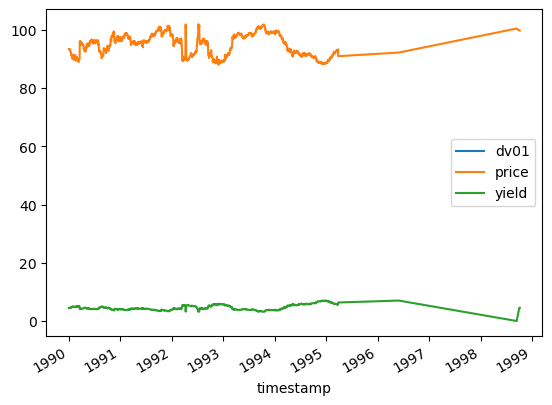

In [14]:
bond_data.xs('US912810BG23', level=1).loc[:, ['dv01', 'price', 'yield']].plot()

In [15]:
final_df.tail()

,,price,yield,dv01
timestamp,id,,,
2024-11-01,US912828Y958,96.083984,4.233,1.618
2024-11-04,US912828Y958,96.15625,4.192,1.617
2024-11-05,US912828Y958,96.128906,4.212,1.614
2024-11-06,US912828Y958,96.013672,4.288,1.609
2024-11-07,US912828Y958,96.109375,4.232,NaN


## Data Cleaning and Interpolation

In [16]:
# First sort the data and reset the index
bond_data.sort_index(level=0, inplace=True)
bond_data_reset = bond_data.reset_index()
bond_data_reset.columns

Index(['timestamp', 'id', 'price', 'yield', 'dv01', 'coupon', 'maturity'], dtype='object')

### Prices

In [17]:
# pivot and get dataset only of prices
prices = bond_data_reset.pivot(index="timestamp", columns="id", values="price")
prices.head()

id,US912810BG23,US912810BU17,US912810BX55,US912810BZ04,US912810CC00,US912810CE65,US912810CG14,US912810CK26,US912810CL09,US912810CM81,...,US91282CLD10,US91282CLF67,US91282CLG41,US91282CLH24,US91282CLJ89,US91282CLK52,US91282CLL36,US91282CLM19,US91282CLN91,US91282CLP40
timestamp,,,,,,,,,,,,,,,,,,,,,
1990-01-03,93.546875,100.734375,95.312500,97.578125,101.578125,104.562500,107.609375,118.140625,110.140625,129.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,93.578125,100.921875,95.312500,97.546875,101.515625,104.531250,107.625000,118.000000,110.203125,129.906250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,93.500000,100.796875,95.093750,97.296875,101.328125,104.390625,107.453125,117.843750,110.218750,129.703125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,93.296875,100.390625,94.765625,96.953125,101.046875,104.031250,107.093750,117.484375,110.125000,129.359375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,93.500000,100.375000,94.750000,96.953125,101.093750,104.031250,107.046875,117.562500,110.156250,129.312500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='timestamp'>

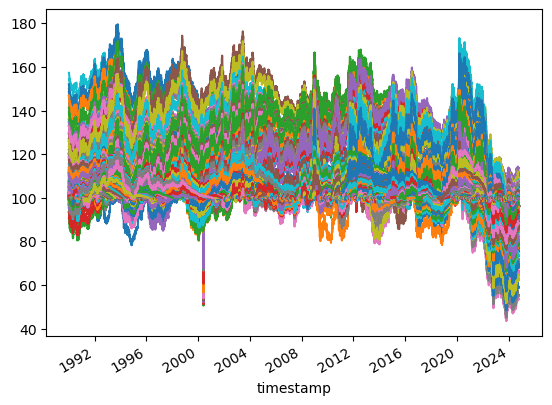

In [18]:
prices.plot(legend=False)

In [19]:
# Before proceeding we interpolate nans only if there is one consecutive
# Function to check single NaN in each column
def is_single_nan(series):
    mask = series.isna()
    # Single NaN is identified as a NaN surrounded by non-NaNs
    return mask & ~mask.shift(1, fill_value=False) & ~mask.shift(-1, fill_value=False)

print(f'previous NaNs: {prices.isna().sum().sum()}')
# Mask for single NaNs
single_nan_mask_prices = prices.apply(is_single_nan)
prices_cleaned = prices.where(~single_nan_mask_prices, prices.interpolate(method='linear', limit=1, axis=0))
print(f'Current NaNs: {prices_cleaned.isna().sum().sum()}')

previous NaNs: 12705927
Current NaNs: 12705300


In [20]:
# Apply the function to replace outliers with NaNs - ideally it will take around 5 minutes to run
def replace_deviations_with_nan(prices, max_change = 0.15): # here set max change to what you consider proper
    for i in tqdm(range(prices.shape[1]), desc="Processing columns"):
        for j in range(1, prices.shape[0]):
            diff = prices.iloc[j, i] - prices.iloc[j-1, i]
            if abs(diff) > max_change * prices.iloc[j-1, i]:
                prices.iloc[j, i] = np.nan
    return prices

prices_cleaned = replace_deviations_with_nan(prices_cleaned)


Processing columns: 100%|██████████| 1625/1625 [05:24<00:00,  5.01it/s]


In [21]:
print(f'previous NaNs: {prices_cleaned.isna().sum().sum()}')
# Mask for multiple Nan (limit = 3)
single_nan_mask_prices = prices_cleaned.apply(is_single_nan)
prices_cleaned = prices_cleaned.where(~single_nan_mask_prices, prices_cleaned.interpolate(method='linear', limit=3, axis=0))
print(f'current NaNs: {prices_cleaned.isna().sum().sum()}')

previous NaNs: 12705316
current NaNs: 12705300


<Axes: xlabel='timestamp'>

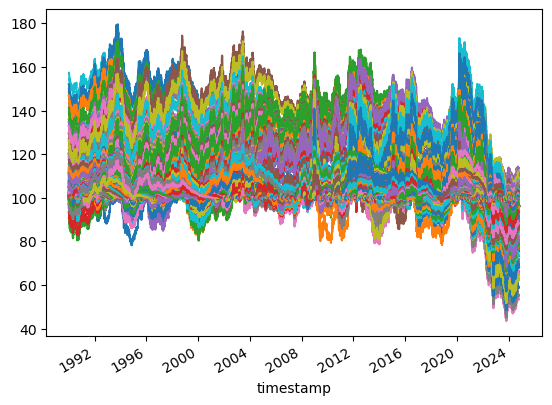

In [22]:
prices_cleaned.plot(legend = False)

In [23]:
prices_cleaned.head(10)

id,US912810BG23,US912810BU17,US912810BX55,US912810BZ04,US912810CC00,US912810CE65,US912810CG14,US912810CK26,US912810CL09,US912810CM81,...,US91282CLD10,US91282CLF67,US91282CLG41,US91282CLH24,US91282CLJ89,US91282CLK52,US91282CLL36,US91282CLM19,US91282CLN91,US91282CLP40
timestamp,,,,,,,,,,,,,,,,,,,,,
1990-01-03,93.546875,100.734375,95.312500,97.578125,101.578125,104.562500,107.609375,118.140625,110.140625,129.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,93.578125,100.921875,95.312500,97.546875,101.515625,104.531250,107.625000,118.000000,110.203125,129.906250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,93.500000,100.796875,95.093750,97.296875,101.328125,104.390625,107.453125,117.843750,110.218750,129.703125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,93.296875,100.390625,94.765625,96.953125,101.046875,104.031250,107.093750,117.484375,110.125000,129.359375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,93.500000,100.375000,94.750000,96.953125,101.093750,104.031250,107.046875,117.562500,110.156250,129.312500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-10,93.468750,100.328125,94.875000,97.125000,101.171875,104.093750,107.062500,117.640625,110.078125,129.406250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-11,93.265625,100.328125,94.687500,96.890625,101.046875,103.968750,106.906250,117.406250,109.906250,129.203125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-12,92.921875,99.984375,94.187500,96.390625,100.500000,103.468750,106.406250,116.828125,109.781250,128.437500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-15,92.828125,99.734375,94.015625,96.203125,100.390625,103.265625,106.312500,116.609375,109.718750,128.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Melt the cleaned price dataset
prices_cleaned.reset_index(inplace=True)
prices_cleaned_melted = prices_cleaned.melt(id_vars=["timestamp"], var_name="id", value_name="price")
prices_cleaned_melted.set_index(['timestamp', 'id'], inplace=True)

In [25]:
# merge cleaned prices with original dataset
bond_data_merged = pd.merge(
    bond_data.drop(columns=["price"]),  # Drop the original price column
    prices_cleaned_melted,
    on=["timestamp", "id"],
    how="right", # prioritize cleaned df
)

bond_data_merged = bond_data_merged.dropna(subset = 'coupon', axis = 0) #use coupon column as reference to drop rows in the dataset as it had 0 nans in the original one
bond_data_merged = bond_data_merged.sort_index()
bond_data_merged

yield   dv01  coupon   maturity       price
timestamp  id                                                       
1990-01-03 US912810BG23  4.386    NaN   3.500 1998-11-15   93.546875
           US912810BU17  8.141    NaN   8.250 2005-05-15  100.734375
           US912810BX55  8.242    NaN   7.625 2007-02-15   95.312500
           US912810BZ04  8.181    NaN   7.875 2007-11-15   97.578125
           US912810CC00  8.179    NaN   8.375 2008-08-15  101.578125
...                        ...    ...     ...        ...         ...
2024-11-01 US912828Y958  4.233  1.618   1.875 2026-07-31   96.083984
2024-11-04 US912828Y958  4.192  1.617   1.875 2026-07-31   96.156250
2024-11-05 US912828Y958  4.212  1.614   1.875 2026-07-31   96.128906
2024-11-06 US912828Y958  4.288  1.609   1.875 2026-07-31   96.013672
2024-11-07 US912828Y958  4.232    NaN   1.875 2026-07-31   96.109375

[2052327 rows x 5 columns]

<Axes: xlabel='timestamp'>

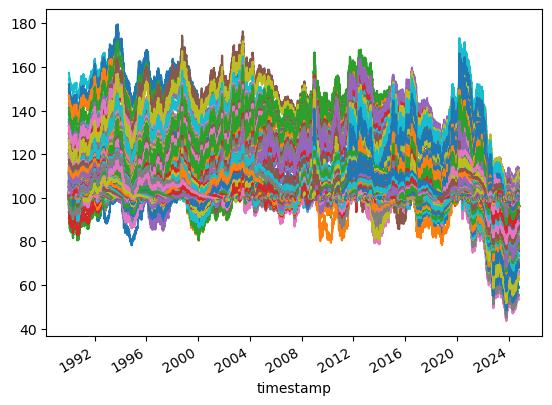

In [26]:
# plot cleaned prices
bond_data_merged_reset = bond_data_merged.reset_index()
prices_merged = bond_data_merged_reset.pivot(index="timestamp", columns="id", values="price")
prices_merged.plot(legend = False)

### Yields

In [27]:
# pivot and get dataset only of prices
yields = bond_data_reset.pivot(index="timestamp", columns="id", values="yield")
yields.head()

id,US912810BG23,US912810BU17,US912810BX55,US912810BZ04,US912810CC00,US912810CE65,US912810CG14,US912810CK26,US912810CL09,US912810CM81,...,US91282CLD10,US91282CLF67,US91282CLG41,US91282CLH24,US91282CLJ89,US91282CLK52,US91282CLL36,US91282CLM19,US91282CLN91,US91282CLP40
timestamp,,,,,,,,,,,,,,,,,,,,,
1990-01-03,4.386,8.141,8.242,8.181,8.179,8.191,8.211,8.234,8.038,8.253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,4.382,8.114,8.242,8.185,8.186,8.195,8.209,8.249,8.023,8.249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,4.394,8.132,8.273,8.217,8.209,8.211,8.228,8.265,8.017,8.268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,4.423,8.191,8.318,8.262,8.244,8.254,8.269,8.302,8.037,8.301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,4.394,8.193,8.320,8.262,8.238,8.254,8.274,8.294,8.029,8.306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='timestamp'>

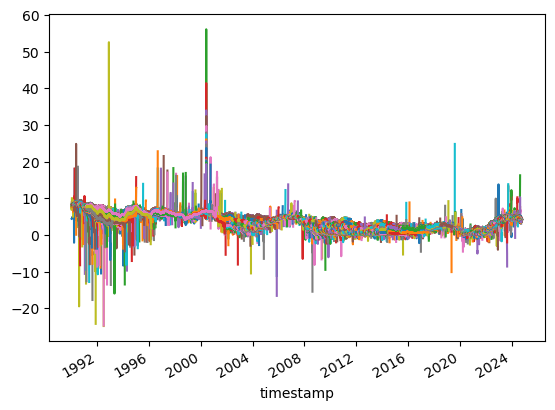

In [28]:
yields.plot(legend = False)

In [29]:
# Before proceeding we interpolate nans only if there is one consecutive
print(f'previous NaNs: {yields.isna().sum().sum()}')
# Mask for single NaNs
single_nan_mask_yields = yields.apply(is_single_nan)
yields_cleaned = yields.where(~single_nan_mask_yields, yields.interpolate(method='linear', limit=1, axis=0))
print(f'Current NaNs: {yields_cleaned.isna().sum().sum()}')

previous NaNs: 12706236
Current NaNs: 12705629


In [30]:
# Function to replace values that deviate by more than 3 standard deviations from the mean
# Apply the function to replace outliers with NaNs
def replace_deviations_with_nan(yields, std1 = 3, std2 = 3, lim_min = -1.5, lim_max = 15): # set parameter you consider more proper
    for i in tqdm(range(yields.shape[0])):
        row_mean = yields.iloc[i].mean()
        row_std = yields.iloc[i].std()
        # Replace values deviating more than 3 standard deviations with NaN
        yields.iloc[i] = yields.iloc[i].where(
            (yields.iloc[i] >= row_mean - std1 * row_std) &
            (yields.iloc[i] <= row_mean +std2 * row_std) & (yields.iloc[i] > lim_min) & (yields.iloc[i] < lim_max),
            np.nan
        )
    return yields

yields_cleaned = replace_deviations_with_nan(yields_cleaned)

print(f'number of NaNs: {yields_cleaned.isna().sum().sum()}')

100%|██████████| 9082/9082 [00:03<00:00, 2485.72it/s]

number of NaNs: 12711743


In [31]:
# Mask for multiple Nan (limit = 3)
single_nan_mask_yields = yields_cleaned.apply(is_single_nan)
yields_cleaned = yields_cleaned.where(~single_nan_mask_yields, yields_cleaned.interpolate(method='linear', limit=3, axis=0))
print(f'current NaNs: {yields_cleaned.isna().sum().sum()}')

current NaNs: 12711098


<Axes: xlabel='timestamp'>

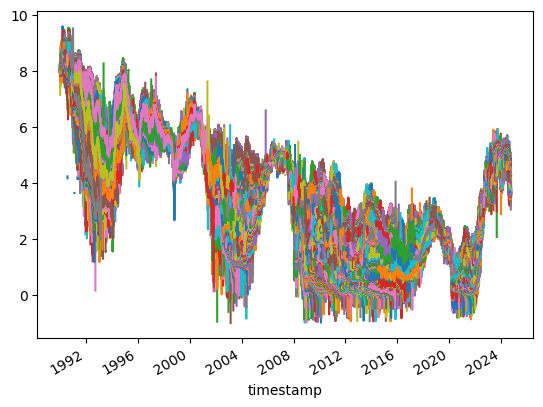

In [32]:
yields_cleaned.plot(legend = False)

In [33]:
# Melt the cleaned price dataset
yields_cleaned.reset_index(inplace = True)
yields_cleaned_melted = yields_cleaned.melt(
    id_vars=["timestamp"], var_name="id", value_name="yield"
)
yields_cleaned_melted.set_index(['timestamp', 'id'], inplace=True)
yields_cleaned_melted

,,yield
timestamp,id,
1990-01-03,US912810BG23,NaN
1990-01-04,US912810BG23,NaN
1990-01-05,US912810BG23,NaN
1990-01-08,US912810BG23,NaN
1990-01-09,US912810BG23,NaN
...,...,...
2024-11-01,US91282CLP40,NaN
2024-11-04,US91282CLP40,NaN
2024-11-05,US91282CLP40,NaN


In [34]:
# merge cleaned prices with original dataset
bond_data_merged = pd.merge(
    bond_data_merged.drop(columns=["yield"]),  # Drop the original price column
    yields_cleaned_melted,
    on=["timestamp", "id"],
    how="right",
)
bond_data_merged = bond_data_merged.dropna(subset = 'coupon', axis = 0) #use coupon column as reference to drop rows in the dataset as it had 0 nans in the original one
bond_data_merged.sort_index(level=0, inplace=True)
bond_data_merged

dv01  coupon   maturity       price  yield
timestamp  id                                                       
1990-01-03 US912810BG23    NaN   3.500 1998-11-15   93.546875    NaN
           US912810BU17    NaN   8.250 2005-05-15  100.734375  8.141
           US912810BX55    NaN   7.625 2007-02-15   95.312500  8.242
           US912810BZ04    NaN   7.875 2007-11-15   97.578125  8.181
           US912810CC00    NaN   8.375 2008-08-15  101.578125  8.179
...                        ...     ...        ...         ...    ...
2024-11-01 US912828Y958  1.618   1.875 2026-07-31   96.083984    NaN
2024-11-04 US912828Y958  1.617   1.875 2026-07-31   96.156250    NaN
2024-11-05 US912828Y958  1.614   1.875 2026-07-31   96.128906    NaN
2024-11-06 US912828Y958  1.609   1.875 2026-07-31   96.013672    NaN
2024-11-07 US912828Y958    NaN   1.875 2026-07-31   96.109375    NaN

[2052327 rows x 5 columns]

### First Datapoint

In [35]:
# add first data point column
def get_issuedt(df):
    # print(df)
    dates = df.index.get_level_values(0)
    # print(dates)
    start_dt = dates.min()
    # print(start_dt)
    return start_dt
first_datapoints = bond_data_merged.groupby(level=1, axis=0).apply(get_issuedt)
first_datapoints.name = 'first_datapoint'
bond_data_merged = bond_data_merged.join(first_datapoints, on='id')
bond_data_merged.head(10)

dv01  coupon   maturity       price  yield  \
timestamp  id                                                         
1990-01-03 US912810BG23   NaN   3.500 1998-11-15   93.546875    NaN   
           US912810BU17   NaN   8.250 2005-05-15  100.734375  8.141   
           US912810BX55   NaN   7.625 2007-02-15   95.312500  8.242   
           US912810BZ04   NaN   7.875 2007-11-15   97.578125  8.181   
           US912810CC00   NaN   8.375 2008-08-15  101.578125  8.179   
           US912810CE65   NaN   8.750 2008-11-15  104.562500  8.191   
           US912810CG14   NaN   9.125 2009-05-15  107.609375  8.211   
           US912810CK26   NaN  10.375 2009-11-15  118.140625  8.234   
           US912810CL09   NaN  10.500 1995-02-15  110.140625  8.038   
           US912810CM81   NaN  11.750 2010-02-15  129.875000  8.253   

                        first_datapoint  
timestamp  id                            
1990-01-03 US912810BG23      1990-01-03  
           US912810BU17      1990-01-03  
           US912810BX55      1990-01-03  
           US912810BZ04      1990-01-03  
           US912810CC00      1990-01-03  
           US912810CE65      1990-01-03  
           US912810CG14      1990-01-03  
           US912810CK26      1990-01-03  
           US912810CL09      1990-01-03  
           US912810CM81      1990-01-03

### Time to Maturity

In [36]:
bond_data_merged['time to maturity'] = (bond_data_merged['maturity'] - bond_data_merged.index.get_level_values(0)) / pd.Timedelta(days=365.25)
bond_data_merged

dv01  coupon   maturity       price  yield  \
timestamp  id                                                          
1990-01-03 US912810BG23    NaN   3.500 1998-11-15   93.546875    NaN   
           US912810BU17    NaN   8.250 2005-05-15  100.734375  8.141   
           US912810BX55    NaN   7.625 2007-02-15   95.312500  8.242   
           US912810BZ04    NaN   7.875 2007-11-15   97.578125  8.181   
           US912810CC00    NaN   8.375 2008-08-15  101.578125  8.179   
...                        ...     ...        ...         ...    ...   
2024-11-01 US912828Y958  1.618   1.875 2026-07-31   96.083984    NaN   
2024-11-04 US912828Y958  1.617   1.875 2026-07-31   96.156250    NaN   
2024-11-05 US912828Y958  1.614   1.875 2026-07-31   96.128906    NaN   
2024-11-06 US912828Y958  1.609   1.875 2026-07-31   96.013672    NaN   
2024-11-07 US912828Y958    NaN   1.875 2026-07-31   96.109375    NaN   

                        first_datapoint  time to maturity  
timestamp  id                                              
1990-01-03 US912810BG23      1990-01-03          8.865161  
           US912810BU17      1990-01-03         15.362081  
           US912810BX55      1990-01-03         17.117043  
           US912810BZ04      1990-01-03         17.864476  
           US912810CC00      1990-01-03         18.614648  
...                                 ...               ...  
2024-11-01 US912828Y958      2019-07-26          1.744011  
2024-11-04 US912828Y958      2019-07-26          1.735797  
2024-11-05 US912828Y958      2019-07-26          1.733060  
2024-11-06 US912828Y958      2019-07-26          1.730322  
2024-11-07 US912828Y958      2019-07-26          1.727584  

[2052327 rows x 7 columns]

### Computing missing yield or prices

In [37]:
def decompose_date(date: datetime.date):
    return date.day, date.month, date.year

In [45]:
# function to price a bond
def price_bond(ytm, current_date, maturity_date, coupon, issue_date):

    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)  # calendar to follow for calculations (NYSE)
    day_count_convention = ql.ActualActual(ql.ActualActual.Bond)  # the day count convention as specified in the bond

    day, month, year = decompose_date(current_date)
    evaluation_date = ql.Date(day, month, year)
    ql.Settings.instance().evaluationDate = evaluation_date

    # initialize bond data
    d, m, y = decompose_date(issue_date)
    issue_date = ql.Date(d, m, y)

    d, m, y = decompose_date(maturity_date)
    maturity_date = ql.Date(d, m, y)

    if evaluation_date == maturity_date:
        return np.nan

    tenor = ql.Period(ql.Semiannual)  # coupon frequency (semiannual)
    date_generation = ql.DateGeneration.Backward
    bussinessConvention = ql.Following
    month_end = False
    face_value = 100

    coupon = coupon


    # create the schedule for the bond
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, bussinessConvention, bussinessConvention,
                           date_generation, month_end)

    # Create the bond
    bond = ql.FixedRateBond(
        settlementDays=1,
        faceAmount=face_value,
        schedule=schedule,
        coupons=[coupon],
        paymentDayCounter=day_count_convention
    )

    return bond.cleanPrice(ytm, day_count_convention, ql.Compounded, ql.Semiannual)

In [46]:
# funtion to compute yield
def yield_bond(price, current_date, maturity_date, coupon, issue_date):

    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)  # calendar to follow for calculations (NYSE)
    day_count_convention = ql.ActualActual(ql.ActualActual.Bond)  # the day count convention as specified in the bond

    day, month, year = decompose_date(current_date)
    evaluation_date = ql.Date(day, month, year)
    ql.Settings.instance().evaluationDate = evaluation_date

    # initialize bond data
    d, m, y = decompose_date(issue_date)
    issue_date = ql.Date(d, m, y)

    d, m, y = decompose_date(maturity_date)
    maturity_date = ql.Date(d, m, y)

    if evaluation_date == maturity_date:
        return np.nan

    tenor = ql.Period(ql.Semiannual)  # coupon frequency (semiannual)
    date_generation = ql.DateGeneration.Backward
    bussinessConvention = ql.Following
    month_end = False
    face_value = 100

    coupon = coupon

    # create the schedule for the bond
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, bussinessConvention, bussinessConvention,
                           date_generation, month_end)

    # Create the bond
    bond = ql.FixedRateBond(
        settlementDays=1,
        faceAmount=face_value,
        schedule=schedule,
        coupons=[coupon],
        paymentDayCounter=day_count_convention
    )

    return bond.bondYield(price, day_count_convention, ql.Compounded, ql.Semiannual)

In [47]:
# function to substitute values in the dataset
def calculate_missing_yield_price(df):
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        try:
            # Skip if both price and yield are present
            if not pd.isna(row['price']) and not pd.isna(row['yield']):
                continue

            # Calculate missing price
            if pd.isna(row['price']):
                ytm = row['yield'] / 100
                coupon = row['coupon'] / 100
                tmt = row['time to maturity']
                issue_date = row['first_datapoint']
                current_date = idx[0]  # Extract the first level of the MultiIndex
                maturity_date = row['maturity']
                df.loc[idx, 'price'] = price_bond(ytm, current_date, maturity_date, coupon, issue_date)

            # Calculate missing yield
            if pd.isna(row['yield']):
                price = row['price'] / 100
                coupon = row['coupon'] / 100
                tmt = row['time to maturity']
                issue_date = row['first_datapoint']
                current_date = idx[0]  # Extract the first level of the MultiIndex
                maturity_date = row['maturity']
                df.loc[idx, 'yield'] = yield_bond(price, current_date, maturity_date, coupon, issue_date)

        except Exception as e:
            continue


In [48]:
# apply the function
print(f"previous NaNs: {bond_data_merged['yield'].isna().sum()}")
calculate_missing_yield_price(bond_data_merged)
print(f"current NaNs: {bond_data_merged['yield'].isna().sum()}")

previous NaNs: 5781


Processing rows: 100%|██████████| 2052327/2052327 [00:34<00:00, 59665.06it/s]


current NaNs: 3001


In [49]:
bond_data = bond_data_merged

## Some Data Viz on US Bond - after cleaning

In [50]:
bond_data.isna().sum() / final_df.shape[0]

dv01                0.369079
coupon              0.000000
maturity            0.000000
price               0.000002
yield               0.001462
first_datapoint     0.000000
time to maturity    0.000000
dtype: float64

## Creating the ArcticDB Object

In [44]:
descr = ['USD', 'BOND']

adb_item_usbonds = ArcticDBItem(
    descr=descr, 
    df=bond_data,
)

NameError: name 'ArcticDBItem' is not defined

In [ ]:
output_path: str = str(product["data"])  # type: ignore

adb_item_usbonds.dump_pickle(output_path)